$$\log p(\phi | \{x_i\}) \approx \prod\limits_{i=1}^N \frac{1}{S_i} \sum\limits_{j=1}^{S_i} p(\theta_{ij} | \phi)$$

For normalizing flows 
$$p(\theta_{ij} | \phi) = q_\phi(\theta_{ij})$$

Then a MAP solution for $\phi$ can be obtained by maximizing $\log p(\phi | \{ x_i \})$, which is equivalent to maximizing
$$\sum_{i=1}^N \log \sum\limits_{j=1}^S q_\phi(\theta_{ij})$$


In [1]:
import os
import h5py 
import numpy as np
import fitsio
from tqdm.auto import trange
import astropy.table as aTable
from astropy.cosmology import Planck13

In [2]:
import copy
from nflows import transforms, distributions, flows

import torch
from torch import nn
from torch import optim
import torch.distributions as D

In [3]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
dat_dir = '/tigress/chhahn/provabgs/svda'

In [5]:
if torch.cuda.is_available(): 
    device = torch.device(type='cuda', index=0)
else: 
    device = 'cpu'

# compile $M_*$ posteriors

In [6]:
bgs = aTable.Table.read(os.path.join(dat_dir, 'BGS_ANY_full.provabgs.hdf5'))

In [7]:
bgs[:5]

TARGETID,RA,DEC,Z_HP,ZERR,TSNR2_BGS,MAG_G,MAG_R,MAG_Z,MAG_W1,FIBMAG_R,HPIX_64,"provabgs_mcmc [100,13]",provabgs_theta_bf [13],provabgs_z_max,provabgs_logMstar_bf,provabgs_logMstar [100],SCHLEGEL_COLOR,provabgs_w_zfail,provabgs_w_fibassign,is_bgs_bright,is_bgs_faint
int64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool
39633390185481181,191.17913199949842,60.25733587654764,0.2004070714061304,nan,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0 .. -999.0,-999.0 .. -999.0,-999.0,-999.0,-999.0 .. -999.0,-999.0,-999.0,129.0,False,False
39633390164510024,188.6998080571996,60.21175772175424,0.2004070714061304,nan,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0 .. -999.0,-999.0 .. -999.0,-999.0,-999.0,-999.0 .. -999.0,-999.0,-999.0,3.225,False,False
39633390185480955,191.14955067198017,60.34047183206205,0.2004070714061304,nan,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0 .. -999.0,-999.0 .. -999.0,-999.0,-999.0,-999.0 .. -999.0,-999.0,-999.0,129.0,False,False
39633390185480938,191.14757099005186,60.345815959235,0.2819459922463374,2.191690764397e-05,1361.7778,20.420939956138607,19.440977833152942,18.807486906915823,18.725561063547207,21.083244145949642,11226,11.091623656909688 .. 0.3684622521221414,11.14249424405227 .. 0.3651476796540595,0.2891440449335749,10.894820213317871,10.848259925842285 .. 10.952618598937988,0.1059712957858181,1.0369954283580962,3.0714285714285716,True,False
39633416324383107,187.05117249536465,62.614542270156655,0.2703579310142208,0.00018002802349298926,1218.0295,20.876585604498494,19.373871860075226,18.567397256862876,18.32574859422363,20.212708263179056,11251,11.127879812361321 .. 0.6691898790548064,11.16028636319183 .. 0.6710591095679554,0.2822033708476234,10.909546852111816,10.877055168151855 .. 10.874772071838379,-0.3616078306686752,1.0018031916676053,1.0,True,False


In [8]:
has_posterior = (bgs['provabgs_z_max'].data != -999.)
is_bgs_bright = bgs['is_bgs_bright']
is_bgs_faint = bgs['is_bgs_faint']

In [9]:
bgs = bgs[has_posterior & is_bgs_bright]
print('%i BGS Bright galaxies with posteriors' % len(bgs))

143017 BGS Bright galaxies with posteriors


# calculate $V_{\rm max}$ with *Planck (2013)* cosmology

In [10]:
bgs['Vmax'] = Planck13.comoving_volume(bgs['provabgs_z_max'].data).value * Planck13.h**3 # (Mpc/h)^3

(6.0, 13.0)

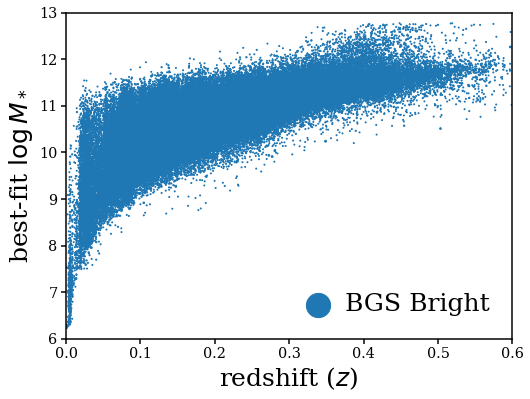

In [13]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.scatter(bgs['Z_HP'].data, bgs['provabgs_logMstar_bf'].data, 
            s=bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign'].data, c='C0', label='BGS Bright')
sub.legend(loc='lower right', fontsize=25, markerscale=10, handletextpad=0.1)
sub.set_xlabel(r"redshift ($z$)", fontsize=25)
sub.set_xlim(0., 0.6)
sub.set_ylabel(r"best-fit $\log M_*$", fontsize=25)
sub.set_ylim(6., 13.)

In [14]:
logM_posteriors = bgs['provabgs_logMstar'].data
vmaxes = bgs['Vmax'].data

(7.0, 12.5)

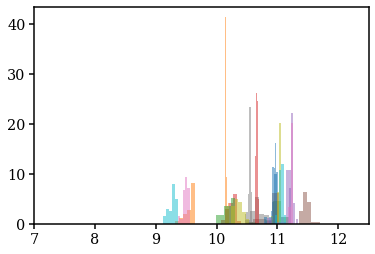

In [15]:
for i in np.random.choice(np.arange(logM_posteriors.shape[0]), size=20, replace=False): 
    plt.hist(logM_posteriors[i,:], bins=5, alpha=0.5, density=True)
plt.xlim(7., 12.5)

# estimate $p(M_* | \{x_i, z_i \})$ in $z$ bins --- incorrectly

Lets just look at the median of the posteriors

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


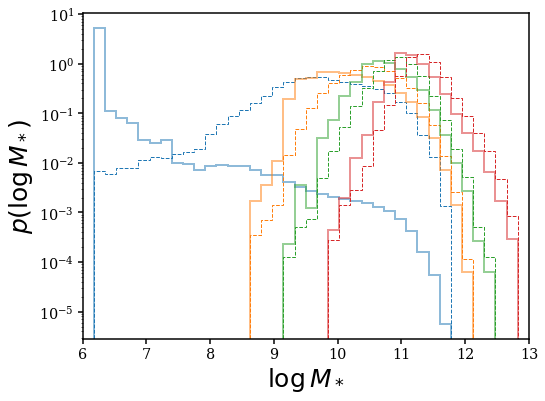

In [19]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
for i, zmin, zmax in zip(range(4), [0., 0.1, 0.2, 0.3], [0.1, 0.2, 0.3, 0.4]):
    # Vmax based importance weights
    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax) & bgs['is_bgs_bright']

    v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 # (Mpc/h)^3
    
    w_import = (v_zmax - v_zmin) / (vmaxes.clip(v_zmin, v_zmax) - v_zmin) 
    w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']
    
    _ = sub.hist(np.median(logM_posteriors[zlim], axis=1), bins=40, range=(6., 13.), color='C%i' % i, 
                 linestyle='--', histtype='step', density=True)
    _ = sub.hist(np.median(logM_posteriors[zlim], axis=1), weights=w_import[zlim], bins=40, range=(6., 13.), 
                 color='C%i' % i, linewidth=2, histtype='step', alpha=0.5, density=True)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(6., 13)
sub.set_ylabel(r'$p(\log M_*)$', fontsize=25)
sub.set_yscale('log')
plt.show()

# estimate $p(M_* | \{x_i, z_i \})$ in $z$ bins --- correctly

In [20]:
def normflow(ndim, nhidden, nblocks): 
    blocks = []
    for iblock in range(nblocks): 
        blocks += [
            transforms.MaskedAffineAutoregressiveTransform(
                features=ndim, 
                hidden_features=nhidden, 
                use_residual_blocks=True)#, transforms.RandomPermutation(features=ndim)
        ]
    transform = transforms.CompositeTransform(blocks)

    # Define a base distribution.
    base_distribution = distributions.StandardNormal(shape=[ndim])

    # Combine into a flow.
    return flows.Flow(transform=transform, distribution=base_distribution)


class GaussianMixtureModel(nn.Module):
    def __init__(self, n_components: int=2):
        super().__init__()
        logweights = torch.zeros(n_components, )
        means   = torch.randn(n_components, ) + 10.
        logstdevs  = 0.1 * torch.tensor(np.random.randn(n_components, ))
        self.logweights = torch.nn.Parameter(logweights)
        self.means   = torch.nn.Parameter(means)
        self.logstdevs  = torch.nn.Parameter(logstdevs)
    
    def forward(self, x):
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        return - gmm.log_prob(x).mean()
    
    def log_prob(self, x): 
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        return gmm.log_prob(x)
    
    def sample(self, N):
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        
        return gmm.sample(N)
    
    
def Loss(qphi, post, w): 
    ''' calculate loss
    
    \sum_i^Ng w_i * \log \sum_j^Ns qphi(\theta_ij)
    
    '''
    logqphi = qphi.log_prob(post.flatten()[:,None]).reshape(post.shape)

    return -torch.sum(w * torch.logsumexp(logqphi, axis=1))  

GMM with 36 components


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>248 	 -7.68809e+00
GMM with 17 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>341 	 -7.70357e+00
GMM with 44 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>238 	 -7.67251e+00
GMM with 81 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>239 	 -7.67040e+00
GMM with 44 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>245 	 -7.64839e+00


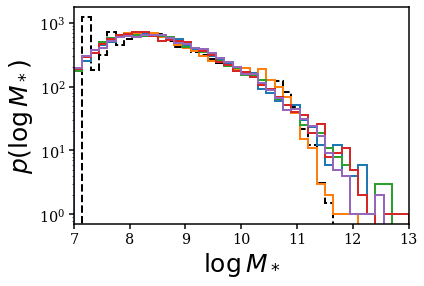

GMM with 85 components


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>202 	 -8.20466e+00
GMM with 21 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>209 	 -8.20677e+00
GMM with 93 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>240 	 -8.21913e+00
GMM with 71 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>230 	 -8.21819e+00
GMM with 87 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>240 	 -8.21841e+00


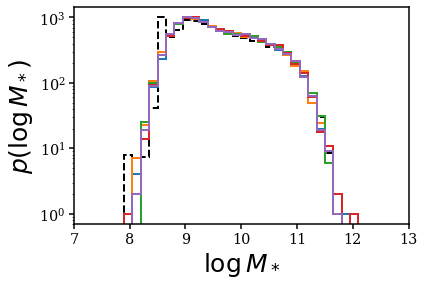

GMM with 48 components


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>219 	 -5.07509e+00
GMM with 72 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>221 	 -5.07332e+00
GMM with 8 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>232 	 -5.07015e+00
GMM with 20 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>244 	 -5.07269e+00
GMM with 55 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>207 	 -5.06850e+00


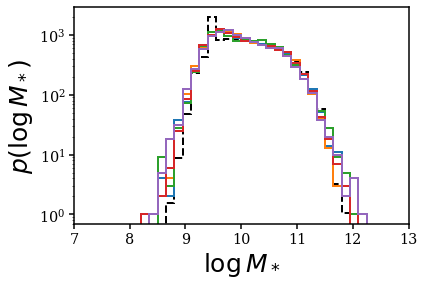

GMM with 48 components


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>161 	 -5.63256e+00
GMM with 5 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>187 	 -5.63137e+00
GMM with 82 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>162 	 -5.63273e+00
GMM with 10 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>169 	 -5.63287e+00
GMM with 51 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>176 	 -5.63227e+00


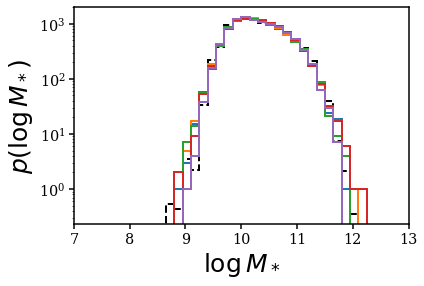

GMM with 13 components


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>129 	 -6.35693e+00
GMM with 50 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>105 	 -6.36621e+00
GMM with 86 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>105 	 -6.36694e+00
GMM with 31 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>107 	 -6.36176e+00
GMM with 57 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>108 	 -6.35916e+00


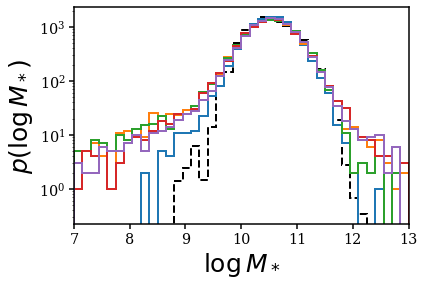

GMM with 82 components


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>286 	 -6.48359e+00
GMM with 9 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>232 	 -6.48050e+00
GMM with 5 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>478 	 -6.47687e+00
GMM with 35 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>285 	 -6.48399e+00
GMM with 29 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>329 	 -6.48488e+00


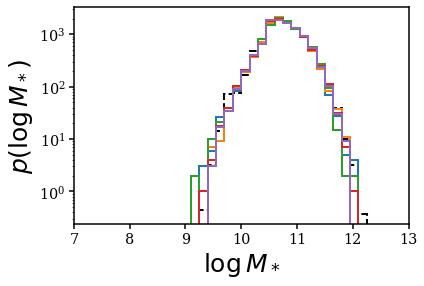

GMM with 35 components


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>264 	 -6.89669e+00
GMM with 52 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>239 	 -6.89764e+00
GMM with 8 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>159 	 -6.88501e+00
GMM with 44 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>270 	 -6.89847e+00
GMM with 26 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>270 	 -6.89790e+00


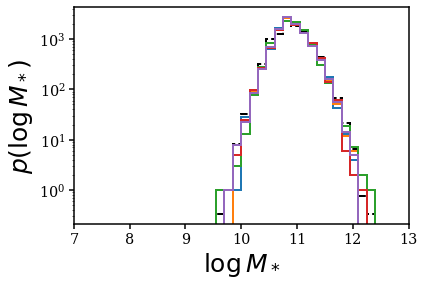

GMM with 81 components


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>297 	 -1.02807e+01
GMM with 58 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>229 	 -1.02694e+01
GMM with 47 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>233 	 -1.02679e+01
GMM with 60 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>213 	 -1.02667e+01
GMM with 10 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>225 	 -1.02674e+01


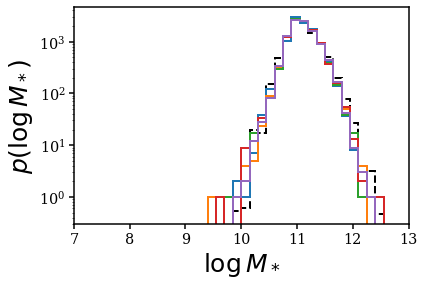

GMM with 28 components


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>351 	 -8.17989e+00
GMM with 14 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>497 	 -8.17908e+00
GMM with 26 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>394 	 -8.17942e+00
GMM with 82 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>411 	 -8.18204e+00
GMM with 51 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>530 	 -8.18676e+00


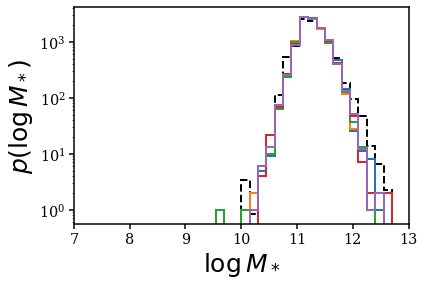

GMM with 83 components


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>391 	 -7.92027e+00
GMM with 76 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>406 	 -7.91935e+00
GMM with 45 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>402 	 -7.92118e+00
GMM with 49 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>361 	 -7.92048e+00
GMM with 26 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>381 	 -7.91751e+00


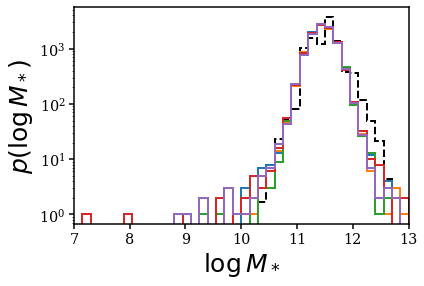

In [34]:
zmins = [0.01 + 0.04 * i for i in range(10)]
zmaxs = [0.01 + 0.04 * (i+1) for i in range(10)]

best_models_z = [] 
for zmin, zmax in zip(zmins, zmaxs):
    # Vmax based importance weights
    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax)

    v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 # (Mpc/h)^3
    
    w_import = (v_zmax - v_zmin) / (vmaxes.clip(v_zmin, v_zmax) - v_zmin) 
    w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']
    
    x_data = torch.tensor(logM_posteriors[zlim].astype(np.float32)).to(device)
    w_data = torch.tensor(w_import[zlim].astype(np.float32)).to(device)
    
    batch_size = 128
    Ntrain = int(0.9 * x_data.shape[0])
    Nvalid = x_data.shape[0] - Ntrain # int(0.1 * x_data.shape[0])

    trainloader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(x_data[:Ntrain], w_data[:Ntrain]),
            batch_size=batch_size,
            shuffle=True)

    validloader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(x_data[Ntrain:], w_data[Ntrain:]),
            batch_size=batch_size)
    
    lr = 1e-3
    num_iter = 1000
    patience = 20

    fig = plt.figure(figsize=(6,4))
    sub = fig.add_subplot(111)
    
    _ = sub.hist(np.median(logM_posteriors[zlim], axis=1), 
             weights=w_import[zlim]*10000./np.sum(w_import[zlim]), 
             range=(7., 13.), bins=40, histtype='step', 
             color='k', linestyle='--', linewidth=2)
    
    best_flows, best_valid_losses, vls = [], [], []
    for i in range(5): 
        ncomp = int(np.random.uniform(5, 100))
        flow = GaussianMixtureModel(n_components=ncomp)
        flow.to(device)
        print('GMM with %i components' % ncomp)

        # parameters = [weights, means, stdevs]
        optimizer = optim.Adam(flow.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer, lr, total_steps=num_iter)

        best_epoch, best_valid_loss = 0, np.inf
        valid_losses = []

        t = trange(num_iter, leave=False)
        for epoch in t:
            train_loss = 0.
            for batch in trainloader: 
                optimizer.zero_grad()
                _post, _w = batch
                _post = _post.to(device)
                _w = _w.to(device)

                loss = Loss(flow, _post, _w)
                loss.backward()
                train_loss += loss.item()
                optimizer.step()
            train_loss /= len(trainloader.dataset)

            with torch.no_grad():
                valid_loss = 0.
                for batch in validloader: 
                    _post, _w = batch
                    _post = _post.to(device)
                    _w = _w.to(device)

                    loss = Loss(flow, _post, _w)                
                    valid_loss += loss.item()
                valid_loss /= len(validloader.dataset)           
                valid_losses.append(valid_loss)

            scheduler.step()

            t.set_description('Epoch: %i TRAINING Loss: %.2e VALIDATION Loss: %.2e' % 
                              (epoch, train_loss, valid_loss), refresh=False)

            if valid_loss < best_valid_loss: 
                best_valid_loss = valid_loss
                best_epoch = epoch
                best_flow = copy.deepcopy(flow)
            else: 
                if best_epoch < epoch - patience: 
                    print('>>>%i \t %.5e' % (epoch, best_valid_loss))
                    break
            
        with torch.no_grad(): 
            post_prime = best_flow.sample((10000,))
            _ = sub.hist(np.array(post_prime.detach().cpu()), range=(7., 13.), bins=40, histtype='step', linewidth=2)

        best_flows.append(best_flow)
        best_valid_losses.append(best_valid_loss)
        vls.append(valid_losses)
        
    sub.set_xlabel(r'$\log M_*$', fontsize=25)
    sub.set_xlim(7., 13.)
    sub.set_ylabel(r'$p(\log M_*)$', fontsize=25)
    sub.set_yscale('log')
    plt.show()
    
    ibest = np.argmin(best_valid_losses)
    best_models_z.append(best_flows[ibest])

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


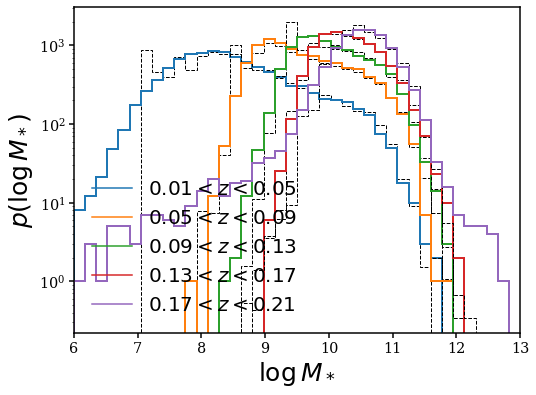

In [39]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
for i, zmin, zmax in zip(range(5), zmins, zmaxs):
    # Vmax based importance weights
    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax)

    v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 # (Mpc/h)^3
    
    w_import = (v_zmax - v_zmin) / (vmaxes.clip(v_zmin, v_zmax) - v_zmin) 
    w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']
    
    psmf_model = best_models_z[i] 
    #torch.load(os.path.join(dat_dir, 'psmf.gmm.bgs_bright.z%.1f_%.1f.1.pt' % (zmin, zmax)), map_location=device)
    with torch.no_grad(): 
        post_prime = psmf_model.sample((10000,))
    
    _ = sub.hist(np.median(logM_posteriors[zlim], axis=1), 
                 weights=w_import[zlim]*10000./np.sum(w_import[zlim]), 
                 range=(6., 13.), bins=40, histtype='step', 
                 color='k', linestyle='--', linewidth=1) 
    
    _ = sub.hist(np.array(post_prime.detach().cpu()), range=(6., 13.), bins=40, 
                 color='C%i' % i, histtype='step', linewidth=2)
    sub.plot([], [], c='C%i' % i, label='$%.2f < z < %.2f$' % (zmin, zmax))

sub.legend(loc='lower left', fontsize=20)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(6., 13.)
sub.set_ylabel(r'$p(\log M_*)$', fontsize=25)
sub.set_yscale('log')
plt.show()

# save pSMF files

In [40]:
for best_model, zmin, zmax in zip(best_models_z[:8], zmins, zmaxs): 
    torch.save(best_model, os.path.join(dat_dir, 'psmf.gmm.bgs_bright.z%.2f_%.2f.best.pt' % (zmin, zmax)))